# Assignment 4 - Solving a finite Element System

In [1]:
#importing modules
import numpy as np
import scipy.sparse as sp
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from petsc4py import PETSc
from scikits import umfpack
import pprint as pprint
import time
import pyamg
from timeit import timeit
from numba import njit, jit, prange
import numba

## Part 1 - Creating the Matrix and Vector

The functions below create a matrix and vector pair that when solved gives an approximate solution to the Helmholtz equation or the reduced wave equation. To do this it uses the Finite element method, for which the accuracy increases as larger matrices are used. This equation provides a mathematical description of waves that can be used for many different applications.

### g(x,y)

First define the g(x,y) as is shown below:

\begin{split}
g(x,y)=
\begin{cases}
\sin(4y)&\text{if }x=0,\\
\sin(3x)&\text{if }y=0,\\
\sin(3+4y)&\text{if }x=1,\\
\sin(3x+4)&\text{if }y=1.
\end{cases}
\end{split}




In [2]:
@jit
def g(x, y):
    """Function given within the task."""
    
    if x == 0:
        return np.sin(4*y)
    if x == 1:
        return np.sin(3 + 4*y)
    if y == 0:
        return np.sin(3*x)
    if y == 1:
        return np.sin(3*x + 4)

### Function to create matrix A vector b for given N

This function defines the required variables for calculations and then creates matrix A and vector b using for-loops. Matrix A is created using a series of if-statements for each (i,j) to check if those two points are diagonally, vertically or horizontally adjacent. The A matrix is then stored in the COO format as it is partially sparse and so for large N this will provide computational and storage efficiencies.

In [3]:
@jit(parallel=True)
def helmholtz_if_loop(N):
    """IF loop for helmholtz mat function, separated for Numba speed up."""
    
    #creating arrays and intialising variables
    k = 5
    h = 1/N
    b = np.zeros((N-1)*(N-1))
    coeff1 = (12 + h*h*k*k)/36
    coeff2 = (3 + h*h*k*k)/9

    #creating b vector
    for j in prange((N-1)*(N-1)):
        #bottom left
        if j == 0:  
            b[j] = coeff1*(g(0,0)+g(2*h,0)+g(0,2*h)) + coeff2*(g(h,0) + g(0,h))
        #bottom right
        elif j == (N-2):
            b[j] = coeff1*(g(1,0)+g(1,2*h)+g(1-2*h,0)) + coeff2*(g(1-h,0) + g(1,h))
        #top left
        elif j == (N*N - 3*N + 2):
            b[j] = coeff1*(g(0,1)+g(2*h,1)+g(0,1-2*h)) + coeff2*(g(h,1) + g(0,1-h))
        #top right
        elif j == (N*N - 2*N):
            b[j] = coeff1*(g(1,1)+g(1-2*h,1)+g(1,1-2*h)) + coeff2*(g(1-h,1) + g(1,1-h))
        #first column:
        elif (j%(N-1)) == 0:
            cj = (j/(N-1)+1)*h
            b[j] = coeff1*(g(0,cj+h)+g(0,cj-h)) + coeff2*g(0,cj)
        #last column:
        elif ((j+1)%(N-1)) == 0:
            cj = ( ((j+1)/(N-1)))*h
            b[j] = coeff1*(g(1,cj+h)+g(1,cj-h)) + coeff2*g(1,cj)
        #bottom row:
        elif j < (N-1):
            cj = (j+1)*h
            b[j] = coeff1*(g(cj+h,0)+g(cj-h,0)) + coeff2*g(cj,0)
        #top row:
        elif j > (N*N - 3*N + 1):
            cj = (j - N*N + 3*N -1)*h
            b[j] = coeff1*(g(cj+h,1)+g(cj-h,1)) + coeff2*g(cj,1)
        #other
        else:
            b[j] = 0
            
    return b


def helmholtz_mat(N):
    """Creates a matrix A and vector b creating a vector matrix problem to approximately solve the Hemholtz 
    equation and converts it into a scipy COO format. 
    Returns
    A: (N-1)^2 * (N-1)^2 matrix in COO format
    b: (N-1)^2 vector"""
    
    #creating arrays and intialising variables
    k = 5
    h = 1/N
    A_shape = ((N-1)*(N-1),(N-1)*(N-1))
    data = dict()
    row = dict()
    col = dict()

    #creating matrix A
    #same
    data[0] = np.ones((N-1)*(N-1))*((24 - 4*h*h*k*k)/9)
    row[0] = np.arange((N-1)*(N-1),dtype='int64')
    col[0] = np.arange((N-1)*(N-1),dtype='int64')

    #horizontal 
    data[1] = np.ones((N-1)*(N-1)-1)*((-3 - h*h*k*k)/9)
    row[1] = np.arange((N-1)*(N-1)-1,dtype='int64')
    col[1] = np.arange(1,(N-1)*(N-1),dtype='int64')
    data[1][N-2::N-1] = 0
    data[2] = np.ones((N-1)*(N-1)-1)*((-3 - h*h*k*k)/9)
    row[2] = np.arange(1,(N-1)*(N-1),dtype='int64')
    col[2] = np.arange((N-1)*(N-1)-1,dtype='int64')
    data[2][N-2::N-1] = 0

    #vertical 
    data[3] = np.ones((N-1)*(N-1)-(N-1))*((-3 - h*h*k*k)/9)
    row[3] = np.arange((N-1)*(N-1)-(N-1),dtype='int64')
    col[3] = np.arange((N-1),(N-1)*(N-1),dtype='int64')
    data[4] = np.ones((N-1)*(N-1)-(N-1))*((-3 - h*h*k*k)/9)
    row[4] = np.arange((N-1),(N-1)*(N-1),dtype='int64')
    col[4] = np.arange((N-1)*(N-1)-(N-1),dtype='int64')

    #diagonal
    data[5] = np.ones((N-1)*(N-1)-N)*((-12 - h*h*k*k)/36)
    row[5] = np.arange((N-1)*(N-1)-N,dtype='int64')
    col[5] = np.arange(N,(N-1)*(N-1),dtype='int64')
    data[5][N-2::N-1] = 0
    data[6] = np.ones((N-1)*(N-1)-(N-2))*((-12 - h*h*k*k)/36)
    row[6] = np.arange((N-1)*(N-1)-(N-2),dtype='int64')
    col[6] = np.arange((N-2),(N-1)*(N-1),dtype='int64')
    data[6][::N-1] = 0

    #diagonal
    data[7] = np.ones((N-1)*(N-1)-N)*((-12 - h*h*k*k)/36)
    row[7] = np.arange(N,(N-1)*(N-1),dtype='int64')
    col[7] = np.arange((N-1)*(N-1)-N,dtype='int64')
    data[7][N-2::N-1] = 0
    data[8] = np.ones((N-1)*(N-1)-(N-2))*((-12 - h*h*k*k)/36)
    row[8] = np.arange((N-2),(N-1)*(N-1),dtype='int64')
    col[8] = np.arange((N-1)*(N-1)-(N-2),dtype='int64')
    data[8][::N-1] = 0

    A_data = np.concatenate((data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8]))
    A_row = np.concatenate((row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8]))
    A_col = np.concatenate((col[0],col[1],col[2],col[3],col[4],col[5],col[6],col[7],col[8]))

    b = helmholtz_if_loop(N)
    
    #store in COO format
    A = sp.coo_matrix((A_data,(A_row,A_col)), shape = A_shape)
    
    return A, b

### Testing Helmholtz function

Below the correct matrices and arrays are defined, they matrix created by the function above is then compared to the correct matrices below for validation purposes.

In [4]:
A_3 = np.array([
    [1.4320987654320987, -0.6419753086419753, -0.6419753086419753, -0.4104938271604938],
    [-0.6419753086419753, 1.4320987654320987, -0.4104938271604938, -0.6419753086419753],
    [-0.6419753086419753, -0.4104938271604938, 1.4320987654320987, -0.6419753086419753],
    [-0.4104938271604938, -0.6419753086419753, -0.6419753086419753, 1.4320987654320987],
])
b_3 = np.array([1.7251323007221917, 0.15334285313223067, -0.34843455260733003, -1.0558651156722307])

# A and b for N=4
A_4 = np.array([
    [1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 0.0, 0.0, 0.0],
    [-0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, 0.0, 0.0, 0.0],
    [0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, 0.0, 0.0],
    [-0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0],
    [-0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111],
    [0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444],
    [0.0, 0.0, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, -0.5069444444444444, 0.0],
    [0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 1.972222222222222, -0.5069444444444444],
    [0.0, 0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222],
])
b_4 = np.array([1.4904895819530766, 1.055600747809247, 0.07847904705126368, 0.8311407883427149, 0.0, -0.8765020708205272, -0.6433980946818605, -0.7466392365712349, -0.538021498324083])

In [5]:
#checking validity
A3_mine, b3_mine = helmholtz_mat(3)
A3_mine = A3_mine.todense()
assert np.allclose(A_3,A3_mine)
assert np.allclose(b_3,b3_mine)

A4_mine, b4_mine = helmholtz_mat(4)
A4_mine = A4_mine.todense()
assert np.allclose(A_4,A4_mine)
assert np.allclose(b_4,b4_mine)

## Part 2 - Solving the System

Below some code is written to solve the Helmholtz equation using the finite element method that has been outlined above, the solution is found by solving a matrix-vector problem. This problem is solved below for 3 different matrix sizes to compare the increases in precision that come with smaller finite differences.

/var/folders/jl/d3_kqc4j01s0nzg7v0z19m3w0000gn/T/ipykernel_9224/1676019921.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


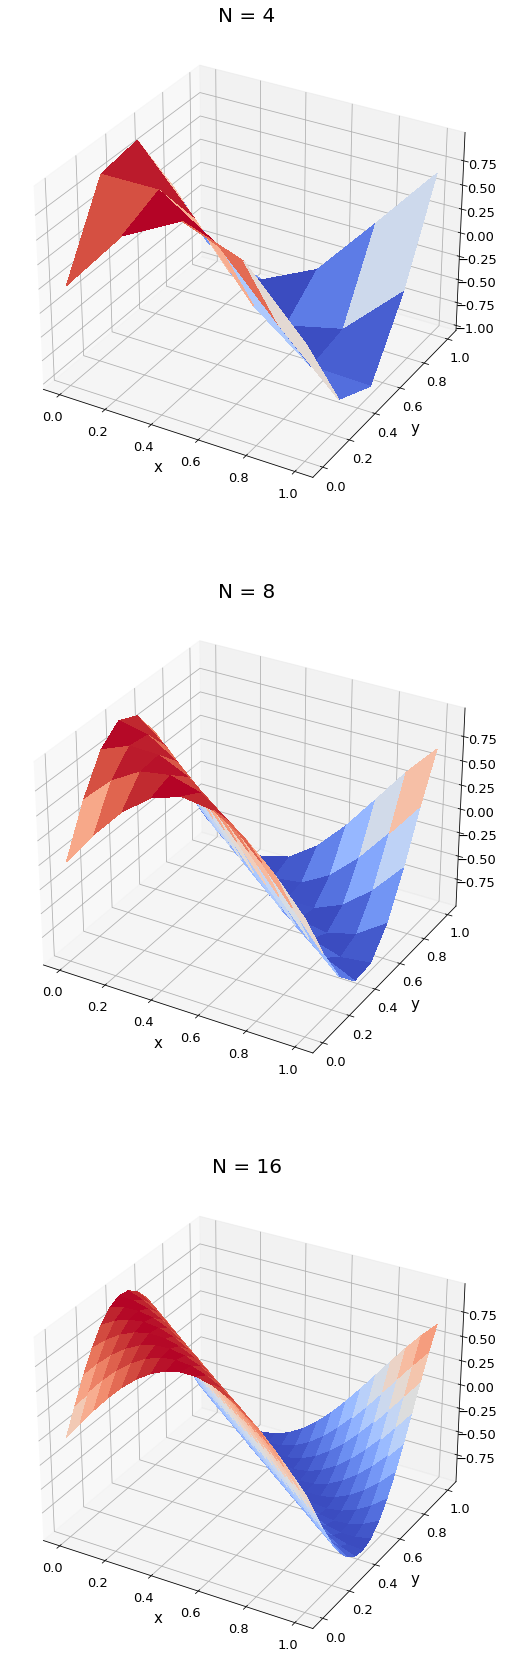

In [15]:
Ns = np.array([4,8,16])

#plotting figures
fig = plt.figure(figsize=(10,30))

#plotting diagrams
for j, N in enumerate(Ns):
    
    #creating solutions matrix
    A, b = helmholtz_mat(N)
    A = A.tocsr()
    u_h = sp.linalg.spsolve(A,b).reshape(N-1,N-1)

    #adding border solutions
    grid = np.linspace(0,1,num=N+1)
    gridx, gridy = np.meshgrid(grid,grid)
    values = np.zeros((N+1,N+1))
    values[1:-1,1:-1] = u_h
    for i in range(N+1):
        values[0,i] = g(gridx[0,i],gridy[0,i])
        values[-1,i] = g(gridx[-1,i],gridy[-1,i])
    for i in range(N-1):
        values[i+1,0] = g(gridx[i+1,0],gridy[i+1,0])
        values[i+1,-1] = g(gridx[i+1,-1],gridy[i+1,-1])
        
    #plotting
    ax = fig.add_subplot(Ns.shape[0], 1, j+1, projection='3d')
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(gridx, gridy, values, antialiased=False, cmap=cm.coolwarm)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_title(f'N = {N}', fontsize=20)

In the plots above we can see the helmholtz function correctly builds a matrix and vector pair that can be solved by a matrix vector solver in an efficient manner. This is shown by the wave-like structure in each of the plots which is exactly what the Helmholtz equation solves. As N is increased the quality of these graphs increase and they become more accurate due to the reduction in size of the finite differences.

## Part 3 - Comparing Solvers and Preconditioners

### Comparison of different Solvers

In this section various matrix-vector solvers are compared. The two direct solvers used are the standard scipy.sparse.linalg.spsolve and the other is PCLU which uses a LU factorisation method. Five iterative methods are also used; these include the original Conjugate Gradient (CG) solver, the Generalised minimal residual (GMRES) solver, the Enhanced BiConjugate Stabilised Gradient (EBiCGSTAB) solver, the least squares method (LSQR) and finally the Algebraic multigrid solver.

In [6]:
def array2petsc4py(A, b):
    """Converts COO matrix A and vector b to PETSc form."""
    A_csr = A.tocsr()
    nnz = A.getnnz(axis =1)
    nnz =nnz.astype('int32')

    A_pet = PETSc.Mat().createAIJ(A.shape, nnz = nnz)
    A_pet.setUp()
    A_pet.setValuesCSR(A_csr.indptr, A_csr.indices, A_csr.data) 
    A_pet.assemble()

    b_pet = A_pet.createVecLeft()
    indices = np.arange(0,b.shape[0],dtype='int32')
    b_pet.setValues(indices,b)
    
    return A_pet, b_pet


def set_solvers(N,tol):
    """Uses N to set up the solvers and returns numpy and PETSc versions of matrix A and vector b. It also sets
    up the ksp values for PETSc and makes them global to be accessed later on."""
    
    A, b = helmholtz_mat(N)
    A_pet, b_pet = array2petsc4py(A, b)
    

    #setting up PETSc solvers
    #Enhanced BiConjugate Gradient
    global ksp3
    ksp3 = PETSc.KSP().create()
    ksp3.setOperators(A_pet)
    ksp3.setType('bcgsl')
    ksp3.setConvergenceHistory()
    ksp3.getPC().setType('none')
    ksp3.setTolerances(rtol=tol)
    #Least Squares
    global ksp4
    ksp4 = PETSc.KSP().create()
    ksp4.setOperators(A_pet)
    ksp4.setType('lsqr')
    ksp4.setConvergenceHistory()
    ksp4.getPC().setType('none')
    ksp4.setTolerances(rtol=tol)
    #Direct LU solver
    global ksp6
    ksp6 = PETSc.KSP().create()
    ksp6.setOperators(A_pet)
    ksp6.setType('preonly')
    ksp6.setConvergenceHistory()
    ksp6.getPC().setType('lu')
    ksp6.setTolerances(rtol=tol)
    
    return A, b, A_pet, b_pet

#### Running the matrix set up function for each of the solvers

The functions used below all accept A in the CSR or the PETSc version of CSR form. The timings made do not include the time taken to transfer the matrix into these formats, they only include times taken for the solver to complete solving of the matrix up to the residual tolerance values defined. The matrices are run until they hit a residual tolerance of $10^{-12}$.

In [ ]:
sp.linalg.spsolve(A.tocsr(),b)

In [30]:
Ns = np.array([10,20,30,40])
methods = ['CG','GMRES','EBiCGSTAB','LSQR','AMG','LU (direct)','spsolve (direct)']
residuals = dict() #residuals dictionary
times = np.zeros((8, Ns.shape[0]))
num_repeats = 1
tol = 10e-12
maxiter = 1000

for i, N in enumerate(Ns):
    #creating matrices
    
    A, b, A_pet, b_pet = set_solvers(N,tol)
    
    #Conjugate gradient
    residuals[1,i] = []
    f_cg = lambda x: residuals[1,i].append(np.linalg.norm(b - A.tocsr() @ x) / np.linalg.norm(b))
    times[1,i] = timeit(lambda: sp.linalg.cg(A.tocsr(), b, tol=tol, callback=f_cg, maxiter=maxiter), 
                            number = num_repeats)  

    #GMRES
    residuals[2,i] = []
    f_gm = lambda res: residuals[2,i].append(res)
    times[2,i] = timeit(lambda: sp.linalg.gmres(A.tocsr(), b, callback=f_gm,tol=tol,maxiter=maxiter), 
                            number = num_repeats)

    #Enhanced BiConjugate Gradient
    x3 = A_pet.createVecRight()
    times[3,i] = timeit(lambda: ksp3.solve(b_pet, x3), number = num_repeats)
    residuals[3,i] = ksp3.getConvergenceHistory()

    #Least Squares
    x4 = A_pet.createVecRight()
    times[4,i] = timeit(lambda: ksp4.solve(b_pet, x4), number = num_repeats)
    residuals[4,i] = ksp4.getConvergenceHistory()

    #Algebraic Multigrid solver
    ml = pyamg.smoothed_aggregation_solver(A.tocsr())
    residuals[5,i] = []
    times[5,i] = timeit(lambda: ml.solve(b, tol=tol, residuals=residuals[5,i], maxiter = maxiter), 
                            number = num_repeats)

    #Direct LU solver
    x6 = A_pet.createVecRight()
    times[6,i] = timeit(lambda: ksp6.solve(b_pet, x6), number = num_repeats)

    #Direct Scipy spsolve
    times[7,i] = timeit(lambda: sp.linalg.spsolve(A.tocsr(),b), number = num_repeats)
    
#clearing old values
del ksp3
del ksp4
del ksp6

### Plotting Comparisons

The graphs below are plots of the residual values of each solver over iterations for a range of matrix sizes.

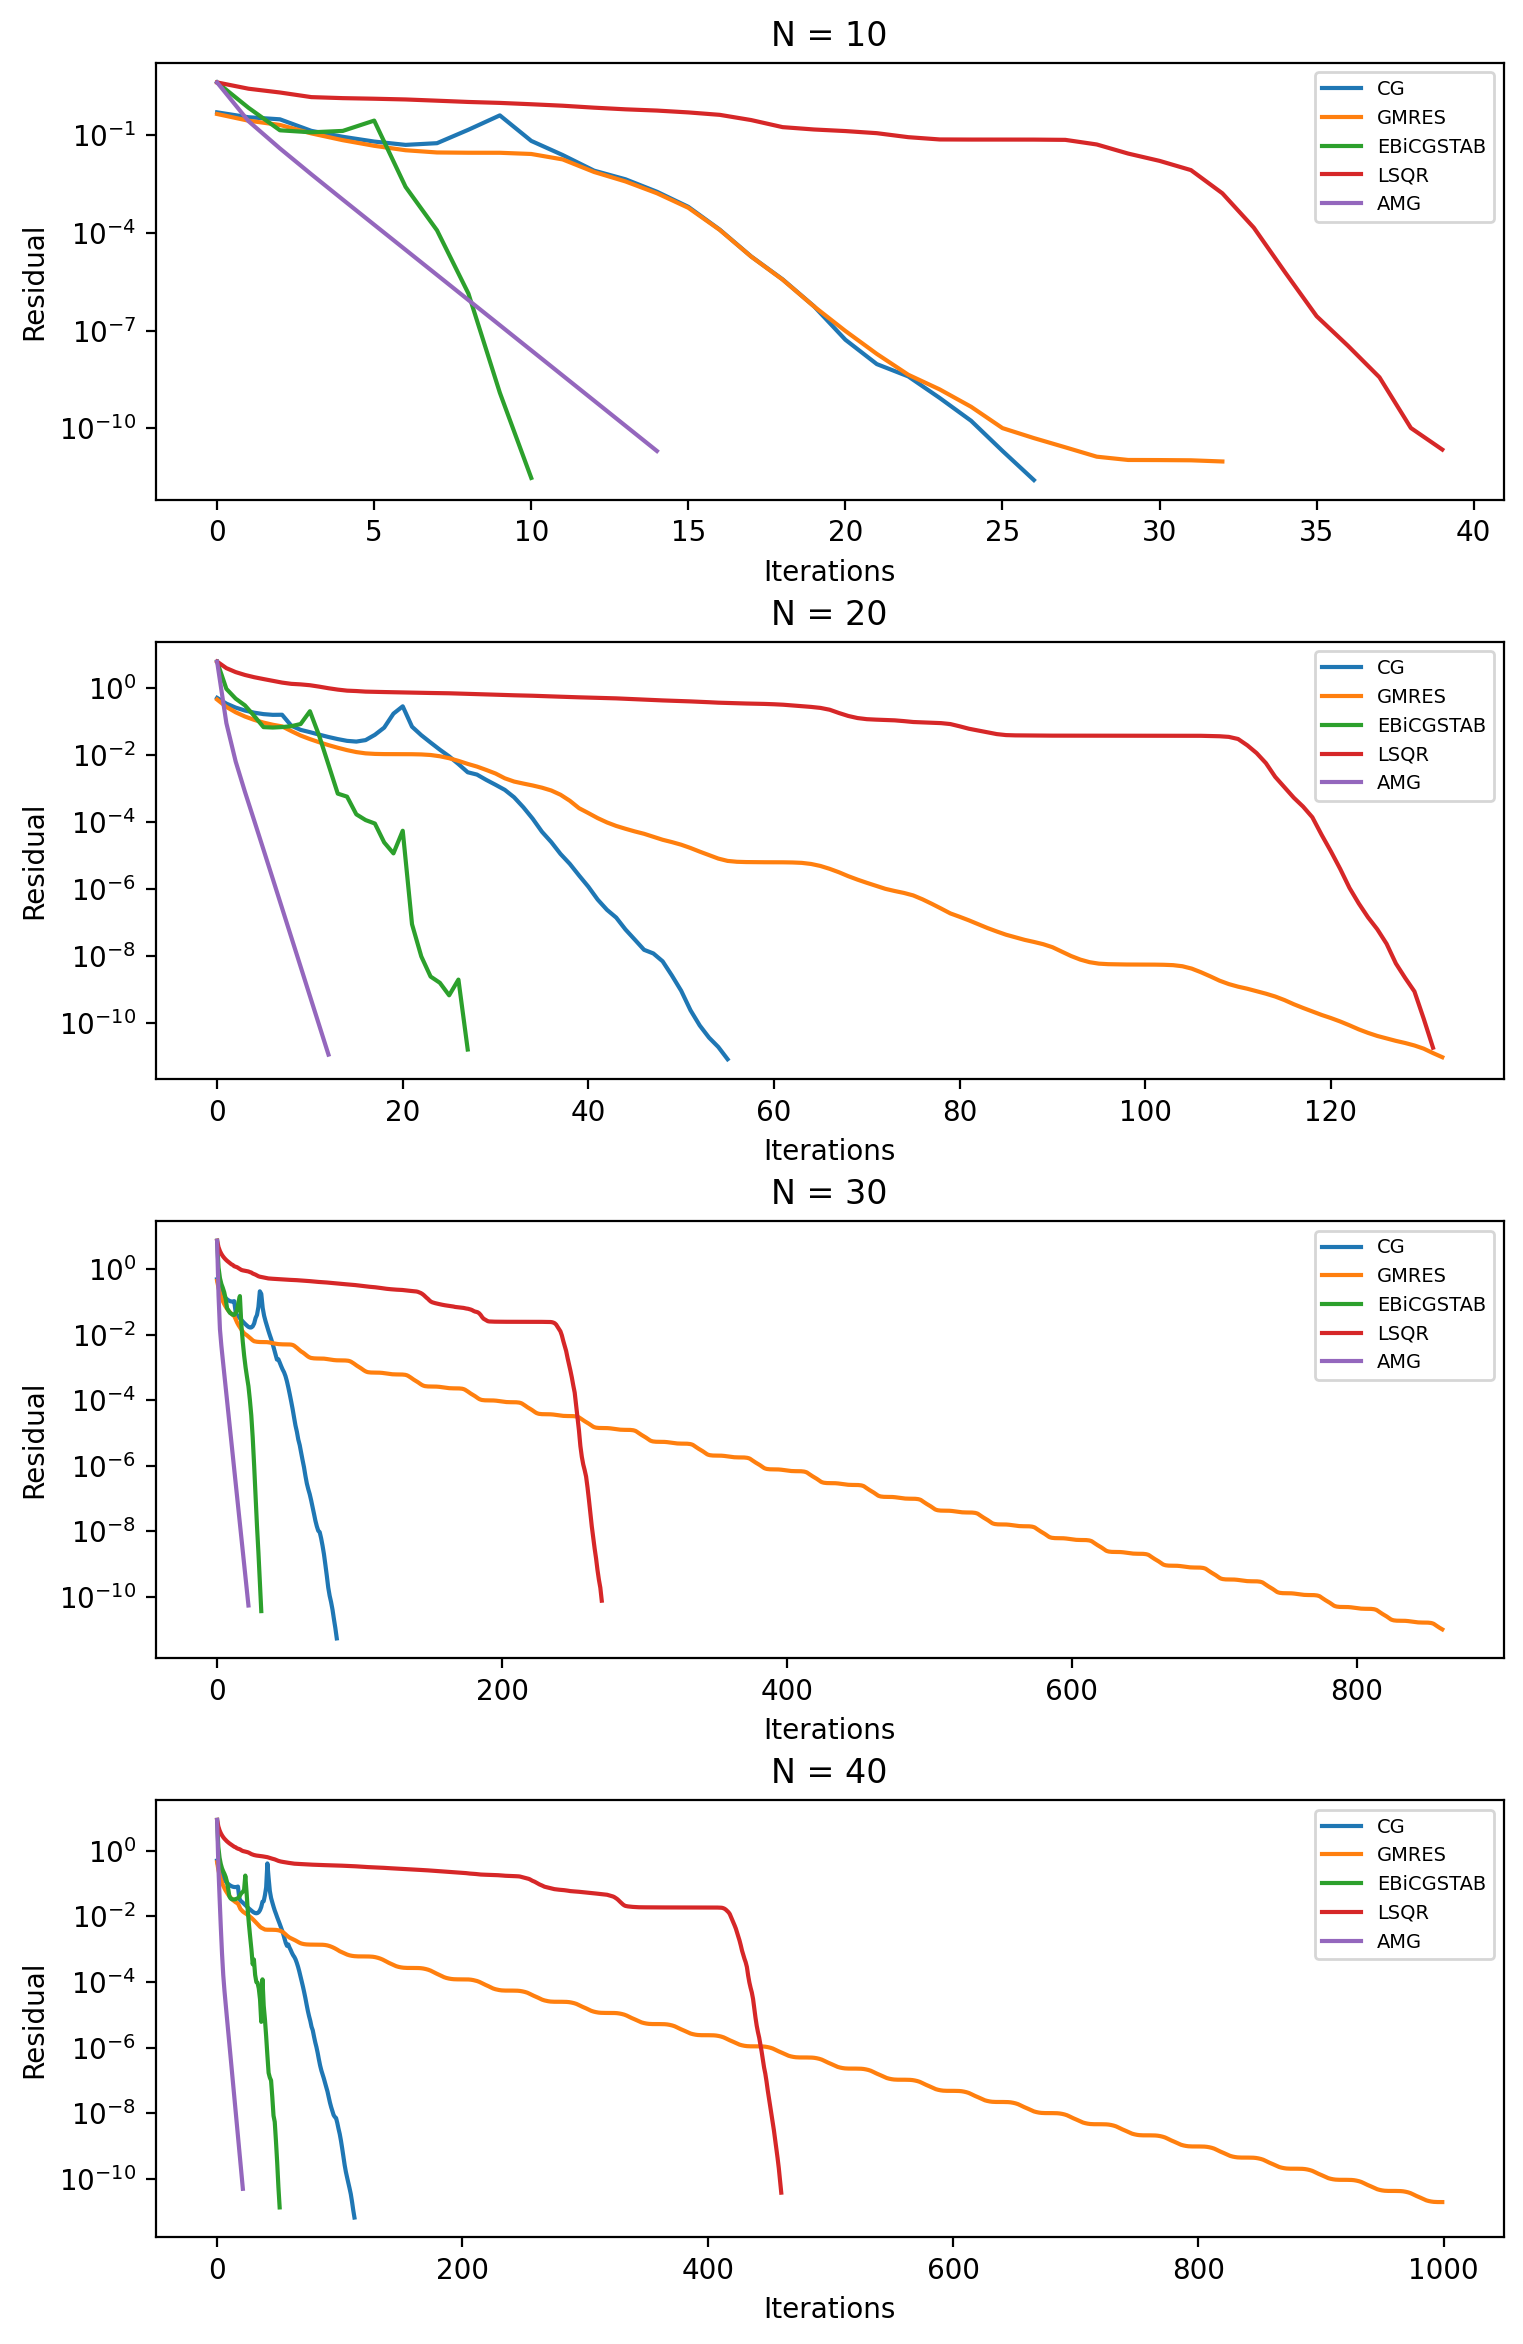

In [35]:
#plotting residuals for each iterative solver
fig, ax = plt.subplots(Ns.shape[0],1,dpi=200, figsize=(8,Ns.shape[0]*3))
fig.tight_layout(pad=3)
for i, size in enumerate(Ns):
    for it_sol in range(5):
        ax[i].semilogy(residuals[it_sol+1,i], label=methods[it_sol])
    ax[i].legend(fontsize=7)
    ax[i].set_xlabel('Iterations')
    ax[i].set_ylabel('Residual')
    ax[i].set_title(f'N = {size}')

In the plots above GMRES is shown to take the largest number of iterations of any solver for matrices N>10, this disparity becomes worse as the size of the matrix increases. The Least Squares solver uses the second most iterations and the most for N=10. The AMG, EBiCGSTAB and CG solvers take the least amount of iterations to reach the  $10^{-12}$ residual tolerance, for each matrix size the AMG solver decreases the fastest, converging after around 20 iterations. The only exception is for the $N=10$ matrix where the EBiCGSTAB solver converges quicker probably due to the simplicity of the matrix and the introduction of more complexity in the AMG function in comparison to the EBiCGSTAB.

The next graph shows the time taken for each of the solvers to find a solution or to converge to their tolerance values over a range of matrix sizes.

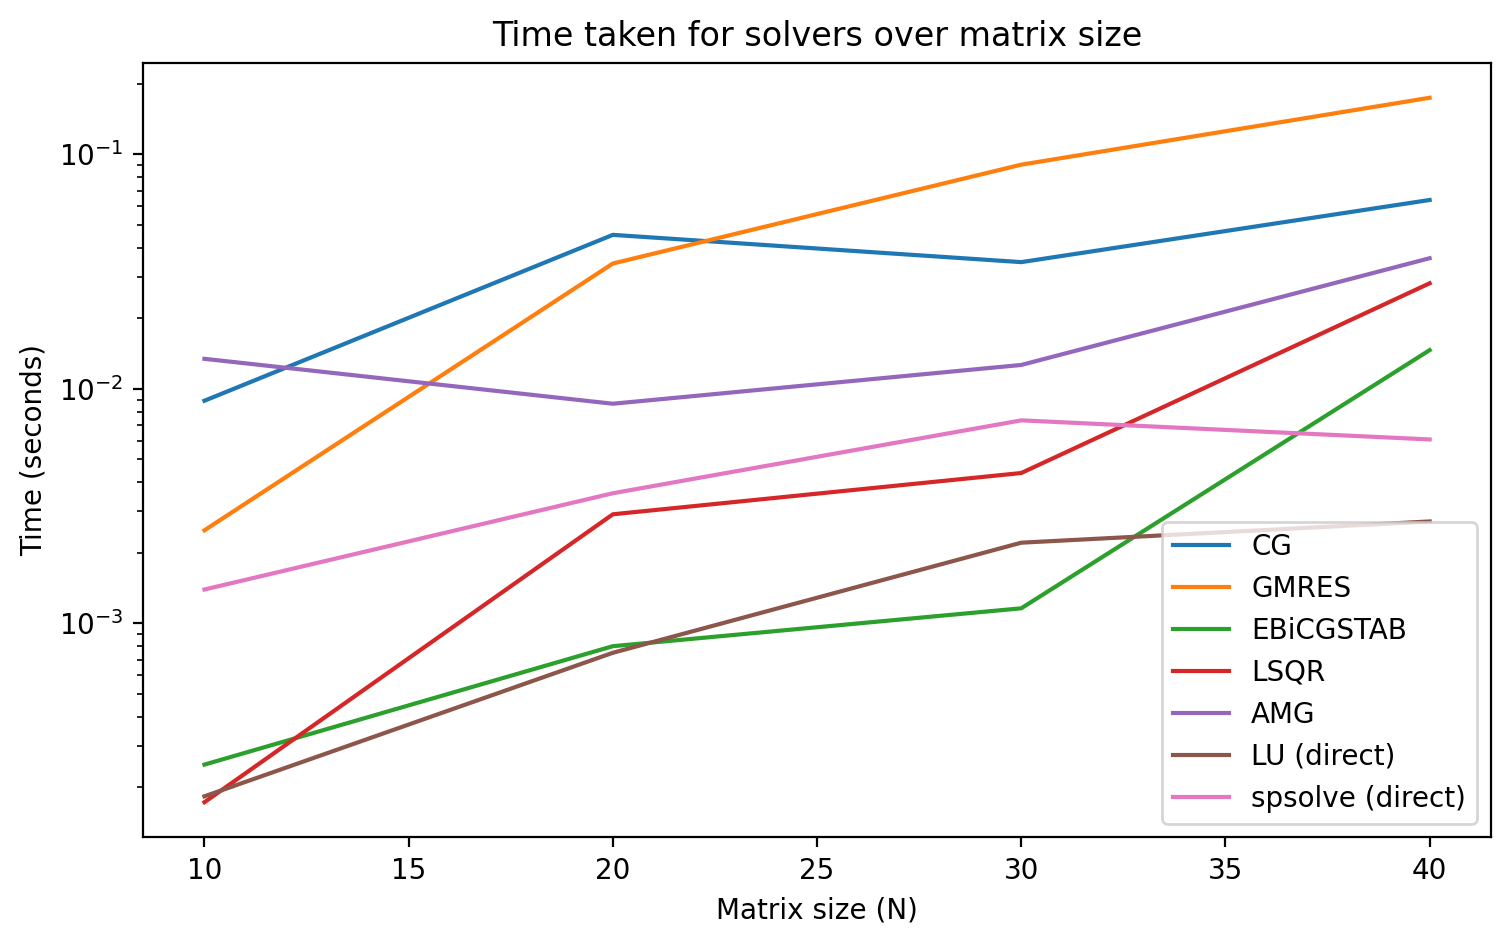

In [36]:
#plotting times taken for each solver
fig, ax = plt.subplots(1,1,dpi=200, figsize=(8,5))
fig.tight_layout(pad=3)

ax.set_title('Time taken for solvers over matrix size')
for i in range(7):
    ax.semilogy(Ns,times[i+1,:], label=methods[i])
    ax.set_xlabel('Matrix size (N)')
    ax.set_ylabel('Time (seconds)')
ax.legend(fontsize=10)

Contrary to the intitial plot, the AMG solver takes an average amount of time to converge in comparison to the other solvers. Here, the EBiCGSTAB and the direct LU solvers are the quickest to find solutions. Once again, GMRES has the slowest performance. Interestingly, the least squares changes from being the fastest solver for $N=10$ and increases to reach average speeds at $N=40$, this might be due to the simplicity of the method using less computational power for more simple matrices but for larger more complex matrices it quickly becomes less effective.


### Comparison of Preconditioners

Below three different preconditioners are compared to each other when applied to the EBiCGSTAB solver and the GMRES solver. GMRES has been chosen as it is the slowest solver and takes the most iterations, therefore it stands to gain the most and can provide a better backdrop for the performance of the preconditioners. Separately, EBiCGSTAB was chosen as it provides a relatively fast performance and so it is interesting to see the improvement in performance that a preconditioner can provide despite its already good performance. The AMG solver was ignored as the mathematical theory beind its use as a solver is poor and it is not know for which matrices it will converge. These two solvers are iterative and have been chosen as the residual plots can provide great insight into the effects of the preconditioner.

The preconditioners selected for comparison are the Algebraic Multigrid (AMG), Symmetric successive over-relaxation (SSOR) and Additive Schwarz (ASM). 

In [27]:
def set_solvers_p(N,tol):
    """Uses N to set up the solvers and returns numpy and PETSc versions of matrix A and vector b. It also sets
    up the ksp values for PETSc and makes them global to be accessed later on."""
    
    A, b = helmholtz_mat(N)
    A_pet, b_pet = array2petsc4py(A, b)

    #setting up PETSc solvers
    
    #Enhanced BiConjugate Gradient
    #AMG
    global ksp_p1
    ksp_p1 = PETSc.KSP().create()
    ksp_p1.setOperators(A_pet)
    ksp_p1.setType('bcgsl')
    ksp_p1.setConvergenceHistory()
    ksp_p1.getPC().setType('gamg')
    ksp_p1.setTolerances(rtol=tol)
    #SOR
    global ksp_p2
    ksp_p2 = PETSc.KSP().create()
    ksp_p2.setOperators(A_pet)
    ksp_p2.setType('bcgsl')
    ksp_p2.setConvergenceHistory()
    ksp_p2.getPC().setType('sor')
    ksp_p2.setTolerances(rtol=tol)
    #ASM
    global ksp_p3
    ksp_p3 = PETSc.KSP().create()
    ksp_p3.setOperators(A_pet)
    ksp_p3.setType('bcgsl')
    ksp_p3.setConvergenceHistory()
    ksp_p3.getPC().setType('asm')
    ksp_p3.setTolerances(rtol=tol)
    
    #GMRES
    #AMG
    global ksp_p4
    ksp_p4 = PETSc.KSP().create()
    ksp_p4.setOperators(A_pet)
    ksp_p4.setType('gmres')
    ksp_p4.setConvergenceHistory()
    ksp_p4.getPC().setType('gamg')
    ksp_p4.setTolerances(rtol=tol)
    #SOR
    global ksp_p5
    ksp_p5 = PETSc.KSP().create()
    ksp_p5.setOperators(A_pet)
    ksp_p5.setType('gmres')
    ksp_p5.setConvergenceHistory()
    ksp_p5.getPC().setType('sor')
    ksp_p5.setTolerances(rtol=tol)
    #ASM
    global ksp_p6
    ksp_p6 = PETSc.KSP().create()
    ksp_p6.setOperators(A_pet)
    ksp_p6.setType('gmres')
    ksp_p6.setConvergenceHistory()
    ksp_p6.getPC().setType('asm')
    ksp_p6.setTolerances(rtol=tol)
    
    #no preconditioner
    global ksp_p7
    ksp_p7 = PETSc.KSP().create()
    ksp_p7.setOperators(A_pet)
    ksp_p7.setType('gmres')
    ksp_p7.setConvergenceHistory()
    ksp_p7.getPC().setType('none')
    ksp_p7.setTolerances(rtol=tol)
    #ASM
    global ksp_p8
    ksp_p8 = PETSc.KSP().create()
    ksp_p8.setOperators(A_pet)
    ksp_p8.setType('bcgsl')
    ksp_p8.setConvergenceHistory()
    ksp_p8.getPC().setType('none')
    ksp_p8.setTolerances(rtol=tol)
    
    return A, b, A_pet, b_pet

#### Runnning the matrix set up function defined above

In this cell the residual values and the times taken for each of the solver/preconditioner combinations is stored.

In [28]:
Ns_p = np.array([10,20,30,40])
methods_p = ['EBiCGSTAB/AMG','EBiCGSTAB/SOR','EBiCGSTAB/ASM','GMRES/AMG','GMRES/SOR','GMRES/ASM', 
             'GMRES', 'EBiCGSTAB']
residuals_p = dict() #residuals dictionary
times_p = np.zeros((len(methods_p)+1, Ns_p.shape[0]))
num_repeats = 1
tol = 10e-12
maxiter = 1000

for i, N in enumerate(Ns_p):
    
    #creating matrices
    A, b, A_pet, b_pet = set_solvers_p(N,tol)

    #EBiCGSTAB/AMG
    x1 = A_pet.createVecRight()
    times_p[1,i] = timeit(lambda: ksp_p1.solve(b_pet, x1), number = num_repeats)
    residuals_p[1,i] = ksp_p1.getConvergenceHistory()
    
    #EBiCGSTAB/SOR
    x2 = A_pet.createVecRight()
    times_p[2,i] = timeit(lambda: ksp_p2.solve(b_pet, x2), number = num_repeats)
    residuals_p[2,i] = ksp_p2.getConvergenceHistory()
    
    #EBiCGSTAB/ASM
    x3 = A_pet.createVecRight()
    times_p[3,i] = timeit(lambda: ksp_p3.solve(b_pet, x3), number = num_repeats)
    residuals_p[3,i] = ksp_p3.getConvergenceHistory()
    
    #GMRES/AMG
    x4 = A_pet.createVecRight()
    times_p[4,i] = timeit(lambda: ksp_p4.solve(b_pet, x4), number = num_repeats)
    residuals_p[4,i] = ksp_p4.getConvergenceHistory()
    
    #GMRES/SOR
    x5 = A_pet.createVecRight()
    times_p[5,i] = timeit(lambda: ksp_p5.solve(b_pet, x5), number = num_repeats)
    residuals_p[5,i] = ksp_p5.getConvergenceHistory()
    
    #GMRES/ASM
    x6 = A_pet.createVecRight()
    times_p[6,i] = timeit(lambda: ksp_p6.solve(b_pet, x6), number = num_repeats)
    residuals_p[6,i] = ksp_p6.getConvergenceHistory()
    
    #EBiCGSTAB
    x7 = A_pet.createVecRight()
    times[7,i] = timeit(lambda: ksp_p7.solve(b_pet, x7), number = num_repeats)
    residuals_p[7,i] = ksp_p7.getConvergenceHistory()
    
    #GMRES
    x8 = A_pet.createVecRight()
    times_p[8,i] = timeit(lambda: ksp_p8.solve(b_pet, x6), number = num_repeats)
    residuals_p[8,i] = ksp_p8.getConvergenceHistory()
    
#clearing old values
del ksp_p1
del ksp_p2
del ksp_p3
del ksp_p4
del ksp_p5
del ksp_p6
del ksp_p7
del ksp_p8

### Plotting Comparison of the Preconditioners

The first plot shows the different solver/preconditioner combinations residuals plotted over iterations, there are several graphs for each different matrix size.

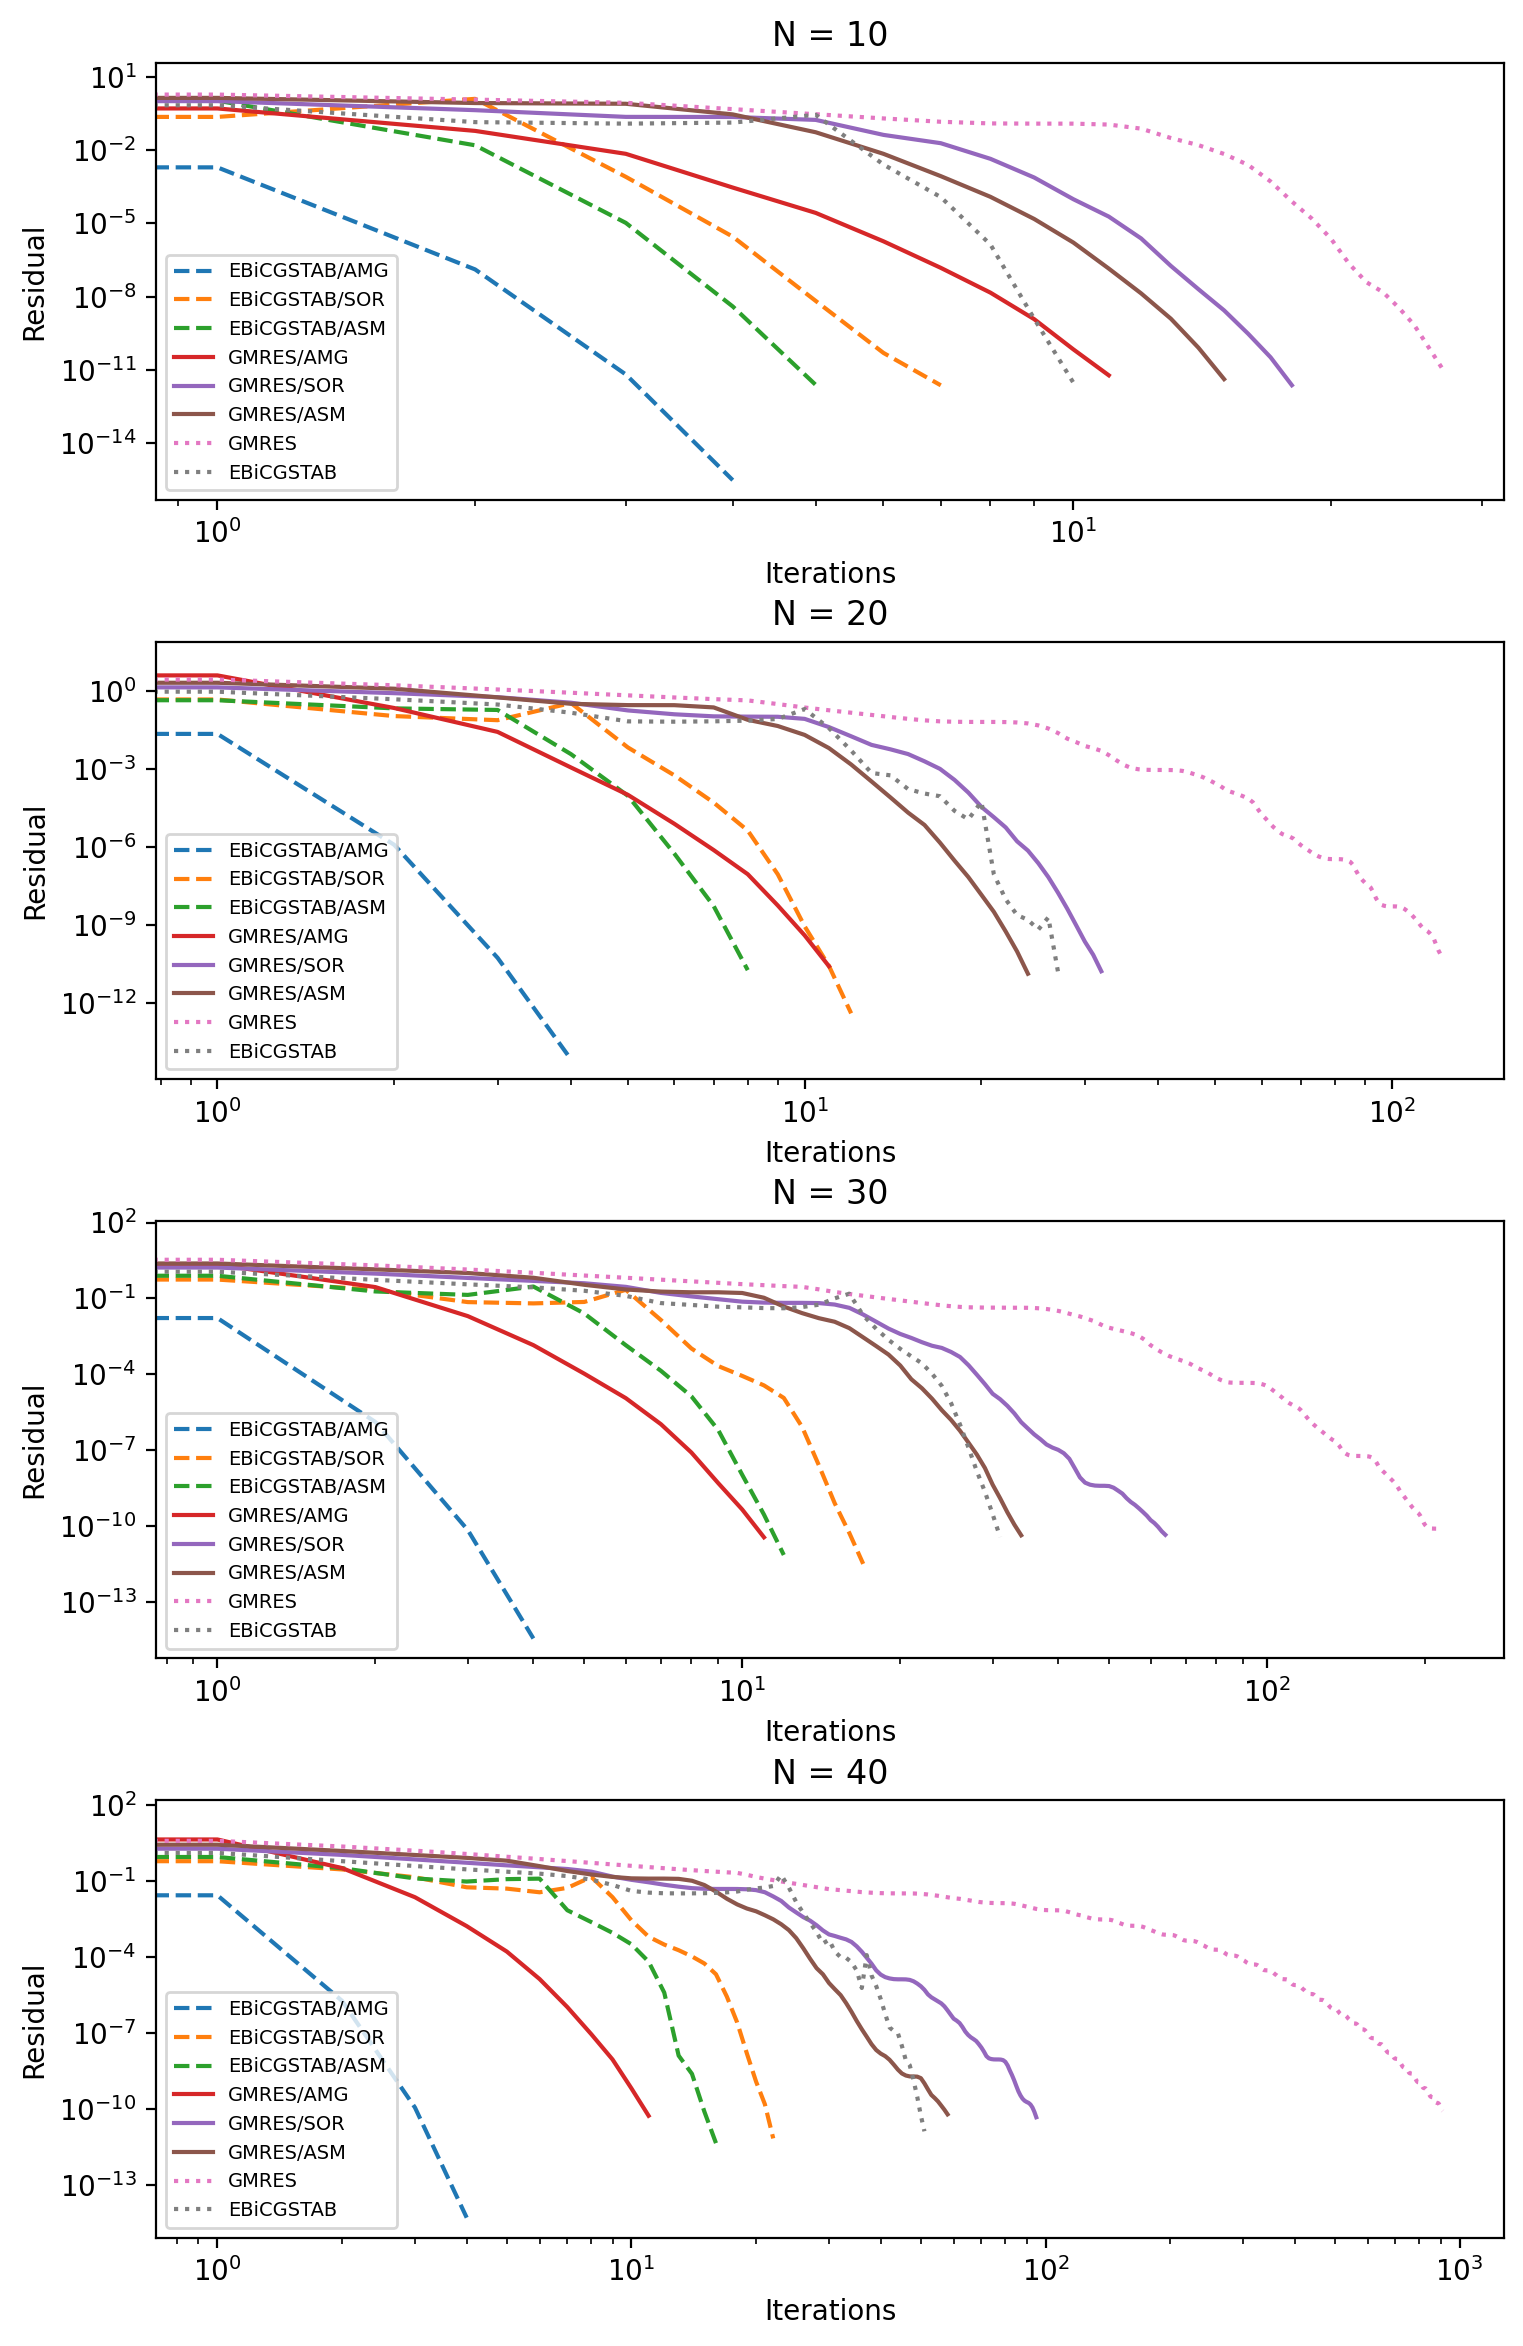

In [50]:
#plotting residuals for each iterative solver
lines_p = ['--','--','--','-','-','-',':',':']
fig, ax = plt.subplots(Ns_p.shape[0],1,dpi=200, figsize=(8,Ns_p.shape[0]*3))
fig.tight_layout(pad=3)
for i, size in enumerate(Ns_p):
    for it_sol in range(len(methods_p)):
        ax[i].loglog(residuals_p[it_sol+1,i], label=methods_p[it_sol], linestyle=lines_p[it_sol])
    ax[i].legend(fontsize=7)
    ax[i].set_xlabel('Iterations')
    ax[i].set_ylabel('Residual')
    ax[i].set_title(f'N = {size}')

The plots above show that all the preconditioners always decrease the number of iterations required for convergence of each of the solvers. The AMG preconditioner brings the largest increase in performance followed by the ASM and then SOR, this is true for both solvers and all matrix sizes. Suprisingly the AMG preconditioner makes the GMRES solver competitive with the EBiCGSTAB solvers even with their own preconditioners applied.

The plot below shows the time taken for the various solver/preconditioner combinations to be applied and to converge to the residual tolerance of $10^{-12}$.

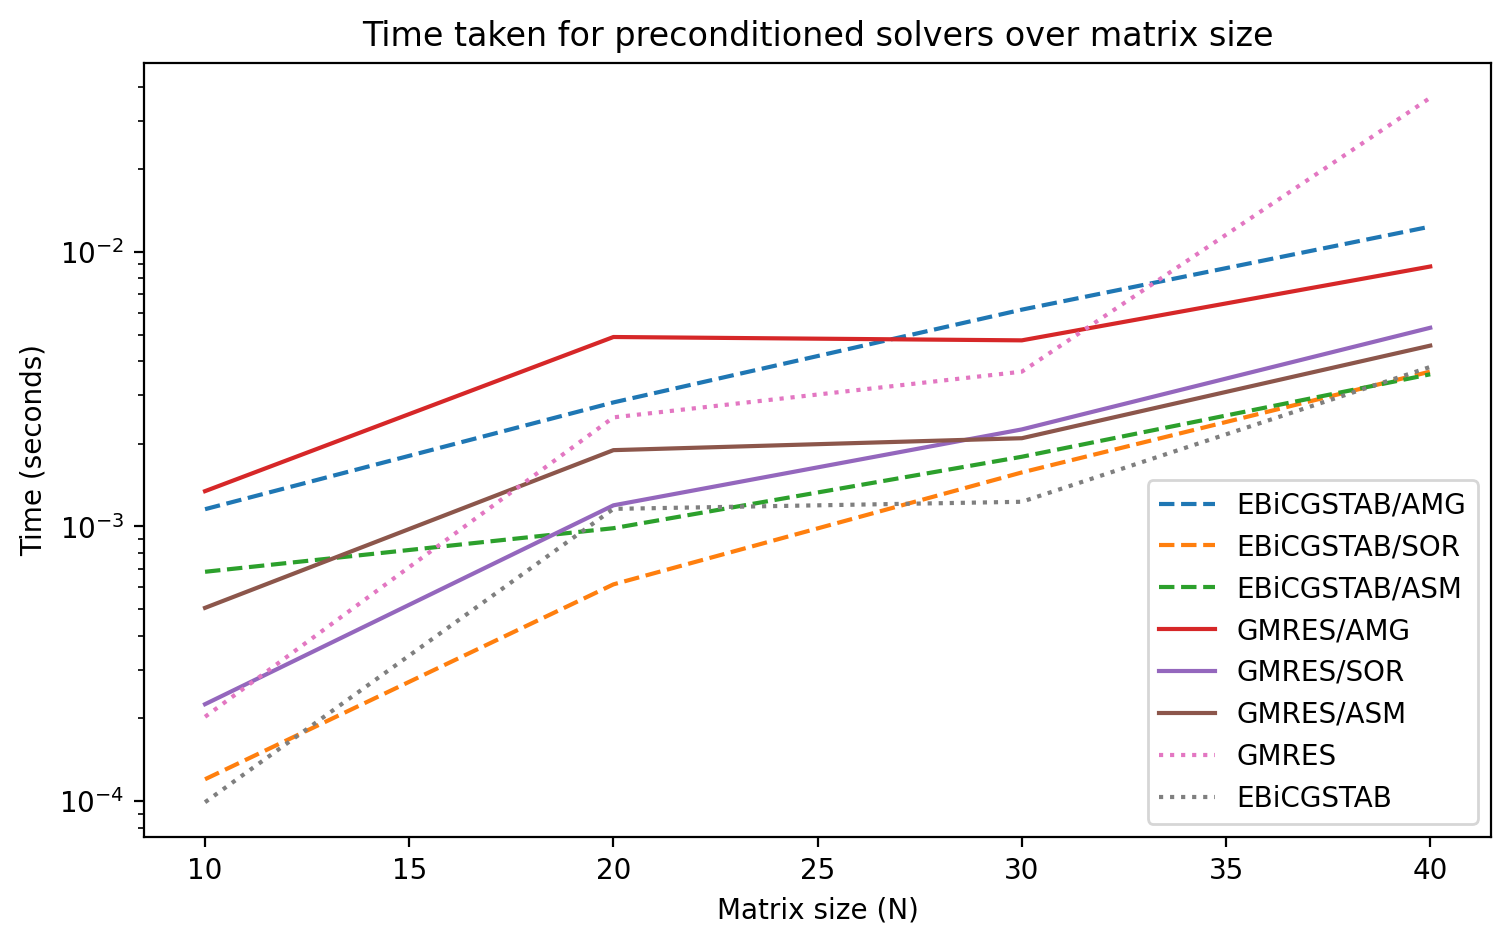

In [36]:
#plotting times taken for each solver
fig, ax = plt.subplots(1,1,dpi=200, figsize=(8,5))
fig.tight_layout(pad=3)

ax.set_title('Time taken for preconditioned solvers over matrix size')
for i in range(len(methods_p)):
    ax.semilogy(Ns_p,times_p[i+1,:], label=methods_p[i], linestyle=lines_p[i])
    ax.set_xlabel('Matrix size (N)')
    ax.set_ylabel('Time (seconds)')
ax.legend(fontsize=10)

Similarly to the un-preconditioned solvers, the solver taking the fewest iterations to converge (EBiCGSTAB/AMG) does not offer the shortest convergence, infact it is acutally the slowest out of all other combinations. Interestingly the EBiCGSTAB with no preconditioner is one of the fastest solvers, this is probably because there is a lack of complexity in the sizes of the matrices tested, such that the extra time for the preconditioner to be found out weighs the efficiencies it provides. From the graph it could be suggested that for larger matrix sizes the EBiCGSTAB/ASM treatement would provide the fastest solutions as it has a smaller gradient than other combinations at higher $N$.

To solve this matrix vector problem in the range surveyed above, I would select the EBiCGSTAB/SOR combination. This is because whilst is has the larget number of iterations for convergence out of any of the EBiCGSTAB combinations, the individual iterations take less time than other solvers. Over the range of matrix sizes considered, this combination provides the fastest (or very close to the fastest) convergence to a solution out of any of the other combinations, providing especially large improvements when $N = 20$. The pure EBiCGSTAB is faster for $N=10$ and $N=30$ but the decrease in times are fairly minimal.

## Part 4 - Increasing N

### Defining Functions

To find the error the $u_h$ value is required to be found in the centre of each of the squares, a function is defined below to take in the solution matrix of $u_h$ values at the corners of each of the squares and output a matrix of $u_h$ values at the midpoint of each of the squares. Then, another function is defined to use this conversion to calculate the error of the iterative solution in comparison to the analytical solution.

In [12]:
@jit(parallel= True)
def PETScToSol_jit(gridx,gridy,values):
    """Part of the PETSc to sol function, separated to apply jit."""
    
    for i in prange(N+1):
        values[0,i] = g(gridx[0,i],gridy[0,i])
        values[-1,i] = g(gridx[-1,i],gridy[-1,i])
    for i in prange(N-1):
        values[i+1,0] = g(gridx[i+1,0],gridy[i+1,0])
        values[i+1,-1] = g(gridx[i+1,-1],gridy[i+1,-1])

    return values



def PETScToSol(x_s,N):
    """Converts the PETSc solutions vector x into a 2d numpy array with border values."""
    
    #PETSc to numpy
    indices = np.arange(0,x_s.getSizes()[0],dtype='int32')
    x_s = x_s.getValues(indices)
    x_s = x_s.reshape(N-1,N-1)
    
    #adding border solutions
    grid = np.linspace(0,1,num=N+1)
    gridx, gridy = np.meshgrid(grid,grid)
    values = np.zeros((N+1,N+1))
    values[1:-1,1:-1] = x_s
    values = PETScToSol_jit(gridx,gridy,values)

    return values

@jit(parallel = True)
def conv_to_mids(x):
    """Takes in the 2d solutions array created from the iterative solver and converts it to an array describing 
    the solutions at the midpoint of the gridpoints instead of the corners of the grid points."""

    N = x.shape[0] - 1
    mids = np.zeros((N,N))
    
    #calculation midpoint vals
    for i in prange(N):
        for j in prange(N):
            mids[i,j] = (x[i,j] + x[i,j+1] + x[i+1,j] + x[i+1,j+1])/4  #averaging
            
    return mids

def error_calc(mids):
    """Takes in the array of solutions evaluated at the midpoints of the gridpoints and compares them to the
    analytical solutions, summing the differences to give a total error."""
    
    N = int(mids.shape[0])
    h = 1/N
    coords = np.linspace(1/(2*N),1-1/(2*N),N)
    xgrid, ygrid = np.meshgrid(coords, coords)
    exact_vals = np.sin(3*xgrid + 4*ygrid)
    error = h*h*np.sum(np.absolute(exact_vals - mids))
    
    return error


def set_solver_s(N,tol):
    """Uses N to set up the selected solver and returns numpy and PETSc versions of matrix A and vector b. It also sets
    up the ksp values for PETSc and makes them global to be accessed later on."""
    
    A, b = helmholtz_mat(N)
    A_pet, b_pet = array2petsc4py(A, b)

    #setting up PETSc solvers
    #Enhanced BiConjugate Gradient/SOR
    global ksp_s
    ksp_s = PETSc.KSP().create()
    ksp_s.setOperators(A_pet)
    ksp_s.setType('bcgsl')
    ksp_s.setConvergenceHistory()
    ksp_s.getPC().setType('sor')
    ksp_s.setTolerances(rtol=tol)
    
    return A, b, A_pet, b_pet

### Running Tests

Below the errors and timings are recorded for the EBiCGSTAB/SOR solver over a range of matrix sizes and stored in arrays for plotting. The calcuation of the error for each of the matrices is defined as:

$$
\sum_{i=0}^{N^2-1} h^2\left|u_\text{exact}(\mathbf{m}_i)-u_h(\mathbf{m}_i)\right|,
$$

where $\mathbf{m_i}$ is the $i$th square in the finite element mesh,  u_\text{exact} is the array of exact solutions and u_\text{h} are the solutions using the approximative method applied above.

In [14]:
number = 5 #number of matrix sizes
Ns_s = np.logspace(1,3.6,number, dtype='int32')
times_s = np.zeros((Ns_s.shape[0]))
error_s = np.zeros((Ns_s.shape[0]))
num_repeats = 1
tol = 10e-12
maxiter = 1000

for i, N in enumerate(Ns_s):
    
    start = time.time()
    
    #creating matrices
    A, b, A_pet, b_pet = set_solver_s(N,tol)
    
    #EBiCGSTAB/SOR
    x_s = A_pet.createVecRight()    
    
    #storing time
    time_start = time.time()
    ksp_s.solve(b_pet, x_s)
    time_end = time.time()
    times_s[i] = time_end-time_start
    
    #finding error
    num_sol = PETScToSol(x_s,N)
    mids = conv_to_mids(num_sol)
    error_s[i] = error_calc(mids)
    
    end = time.time()
    print('Matrix size',N,'takes',np.round(end-start,decimals=2),'seconds')
    
#clearing old values
del ksp_s

Matrix size 10 takes 0.03 seconds
Matrix size 44 takes 0.02 seconds
Matrix size 199 takes 1.51 seconds
Matrix size 891 takes 81.12 seconds
Matrix size 3981 takes 11804.9 seconds


### Plotting Times and Error for various matrix sizes

Below the results from the tests are plotted on loglog graphs to give the best sense of the order of complexity of the solver and convergence of the error. A secondary 'fitting' line is plotted on each to find the order of each of the respective lines. The first graph plots the times taken for the selected EBiCGSTAB/SOR solver/preconditioner combination to the solve the matrix vector problem and the second graph plots the error between the solvers solution and the analytical solution as defined above.

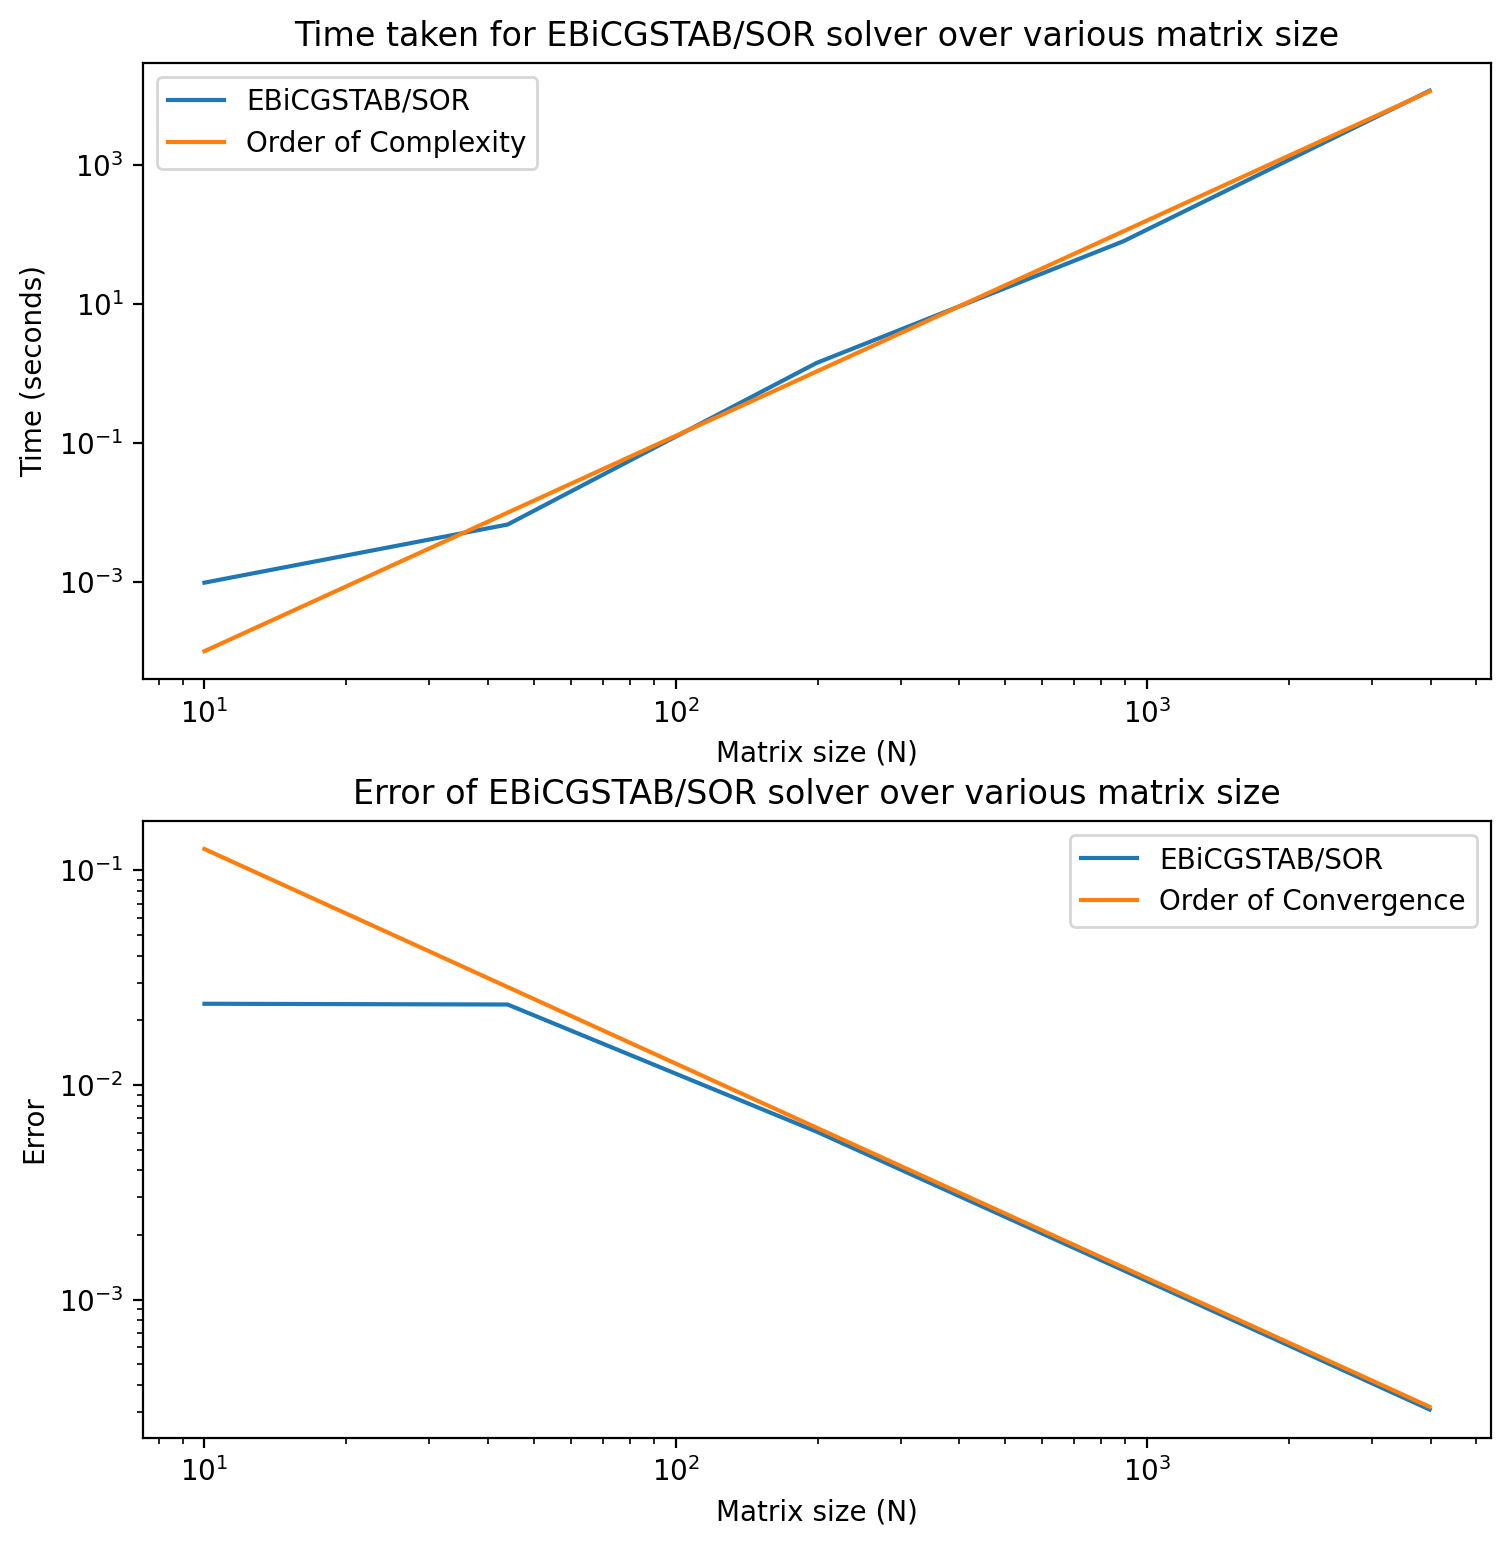

In [23]:
#plotting times taken for each solver
fig, ax = plt.subplots(2,1,dpi=200, figsize=(8,8))
fig.tight_layout(pad=3)

complexO = 3.1 #order of complexity
complex_vals = Ns_s**(complexO)*(10**(-7.1))

ax[0].set_title('Time taken for EBiCGSTAB/SOR solver over various matrix size')
ax[0].loglog(Ns_s,times_s, label='EBiCGSTAB/SOR')
ax[0].loglog(Ns_s,complex_vals, label='Order of Complexity')
ax[0].set_xlabel('Matrix size (N)')
ax[0].set_ylabel('Time (seconds)')
ax[0].legend()


convO = 1.0 #order of convergence
convergence_vals = Ns_s**(-convO)*(10**(0.1))


ax[1].set_title('Error of EBiCGSTAB/SOR solver over various matrix size')
ax[1].loglog(Ns_s,error_s, label='EBiCGSTAB/SOR')
ax[1].loglog(Ns_s,convergence_vals, label='Order of Convergence')
ax[1].set_xlabel('Matrix size (N)')
ax[1].set_ylabel('Error')
ax[1].legend()

In the first plot above, the plotted line is fairly straight above $N=30$, suggesting a clear order of increasing complexity can be found. When the a fitting line was plotted alongside the times the complextiy that fit best was $O(N^{3.1})$. Below $N=30$ the order was slightly lower however this is likely not representative of the actualy complexity as other parts outside of the solver take up proportionally significant amounts of time here.

In the second plot, the error was seen to increase from $N=10$ to $N=30$, then after this it began to decrease exponentially. A similar 'fitting' line was plotted against the error and an order of convergence $O(N^{-1})$ was found to be the best fit.

## Part 5 - Parallelisation

In the code above I originally used a for loop to create my A matrix, causing it to be very slow. I then spent some time trying to increase the speed to get useful results and so ended up implementing some parrelisations. Trivially, I parallelised as many of the for-loops as possible, specifically only those that included pure python or numpy. This was applied to the creation of the b-vector, the conversion from the PETSc matrix to numpy matrix and also the conversion of corner values of the grid-points to their midpoint values. All of these were implemented fairly simply, despite this simplicty, significant increases in computation time of up to a factor of $10^3$ were seen. 

Originally I was using .append() for the A matrix construction which is difficult to parallelise as it needed to be rebuilt such that it would work thread-wise, I ended up creating the A matrix in 8 numpy arrays at once so there was no need to apply parallelisation. The most useful and difficult parts to apply parallelisation to now would be the test cells where various solvers are run over several different matrix sizes, none of these steps depend on each other and could be parallelised but unfortunately Numba does not work with other modules and so another method would have to be found.